In [60]:
import geopandas as gpd
import pandas as pd

from bokeh.io import show, output_notebook, output_file, save
from bokeh.models import (CDSView, ColorBar, ColumnDataSource,
                          CustomJS, CustomJSFilter, 
                          GeoJSONDataSource, HoverTool,
                          LinearColorMapper, Slider, NumeralTickFormatter,
                          Select)
from bokeh.layouts import column, row, widgetbox
from bokeh.palettes import brewer
from bokeh.plotting import figure
from bokeh.io.doc import curdoc

# to plot testing sites
from pyproj import Proj, transform
from bokeh.tile_providers import get_provider, Vendors

# output to html
from bokeh.resources import CDN
from bokeh.embed import file_html

import json

In [61]:
"""
County zipcode map from: https://geodata.lib.berkeley.edu/catalog/ark28722-s7jg7w
"""

# import CA shpfile
sf = gpd.read_file('./data/sanfrancisco/sfcounty_zipcode.shp')
sf.head()

,OBJECTID,ZIP_CODE,ID,geometry
0,1.0,94107.0,94107.0,"POLYGON ((-122.40116 37.78202, -122.40037 37.7..."
1,2.0,94105.0,94105.0,"POLYGON ((-122.39250 37.79377, -122.39189 37.7..."
2,3.0,94129.0,94129.0,"POLYGON ((-122.47099 37.78753, -122.47229 37.7..."
3,4.0,94121.0,94121.0,"POLYGON ((-122.50446 37.78807, -122.50415 37.7..."
4,5.0,94118.0,94118.0,"POLYGON ((-122.44889 37.77839, -122.44977 37.7..."


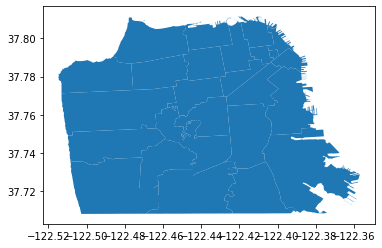

In [62]:
# Let's see what we got
sf.plot()

In [63]:
# Okay. Now that we've created a static map of California's counties, let's import a file for each zipcode's stats
zipcode_data = pd.read_csv("data/sf_zipcode_demograhics.csv")
zipcode_data.head()

,zip_code,Name,population,median_income,percent_white,percent_in_poverty,percent_wo_health_insurance,number_of_testing_sites,predicted_case_rate,current_case_rate,current > predicted?,flag
0,94102,San Francisco,31067,41835,45.2,21.0,7.7,1,47.28,42.8,False,0
1,94103,San Francisco,28735,57015,40.2,20.2,5.5,1,34.21,58.54,True,1
2,94104,San Francisco,546,52679,35.7,21.1,13.2,1,Insufficient data,less than 10,True,1
3,94105,San Francisco,9155,213009,45.3,7.0,2.4,0,15.79,19.54,True,1
4,94107,San Francisco,29689,150451,52.8,10.3,2.2,1,14.60,40.78,True,1


In [64]:
# Take a look at what's inside. 
zipcode_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   zip_code                     27 non-null     int64  
 1   Name                         27 non-null     object 
 2   population                   27 non-null     int64  
 3   median_income                27 non-null     int64  
 4   percent_white                27 non-null     float64
 5   percent_in_poverty           27 non-null     float64
 6   percent_wo_health_insurance  27 non-null     float64
 7   number_of_testing_sites      27 non-null     int64  
 8   predicted_case_rate          27 non-null     object 
 9   current_case_rate            27 non-null     object 
 10  current > predicted?         27 non-null     bool   
 11  flag                         27 non-null     int64  
dtypes: bool(1), float64(3), int64(5), object(3)
memory usage: 2.5+ KB


In [65]:
"""
Prepare the mapping data by converting into a JSON File. 
"""
# Merge shapefile california with county_population. 
merged = sf.merge(zipcode_data, left_on = 'ZIP_CODE', right_on = 'zip_code')

# read data to json
sf_json = json.loads(merged.to_json())

#Convert to String like object.
grid = json.dumps(sf_json)

# Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = grid)

# Let's see what's inside. 
merged.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 25 entries, 0 to 24
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   OBJECTID                     25 non-null     float64 
 1   ZIP_CODE                     25 non-null     float64 
 2   ID                           25 non-null     float64 
 3   geometry                     25 non-null     geometry
 4   zip_code                     25 non-null     int64   
 5   Name                         25 non-null     object  
 6   population                   25 non-null     int64   
 7   median_income                25 non-null     int64   
 8   percent_white                25 non-null     float64 
 9   percent_in_poverty           25 non-null     float64 
 10  percent_wo_health_insurance  25 non-null     float64 
 11  number_of_testing_sites      25 non-null     int64   
 12  predicted_case_rate          25 non-null     object  
 13 

In [66]:
"""
Create colorbar formatting look-up table
"""

# This dictionary contains the formatting for the data in the plots. 
format_data = [('population', 0, 150000, '0,0', 'Population'),
               ('flag', 0, 1,'0,0', 'Testing Capacity Warning'),
               ('percent_white', 0, 100, '0,0', 'Percent Caucasian'), 
               ('percent_in_poverty', 0, 100, '0,0', 'Percent In Poverty'),
               ('percent_wo_health_insurance', 0, 100, '0,0', 'Percent Uninsured'),
               ('median_income', 0, 250000, '0,0', 'Median Income')
              ]

#Create a DataFrame object from the dictionary 
format_df = pd.DataFrame(format_data, columns = ['field' , 'min_range', 'max_range', 'format', 'verbage'])
format_df.head(7)

,field,min_range,max_range,format,verbage
0,population,0,150000,"0,0",Population
1,flag,0,1,"0,0",Testing Capacity Warning
2,percent_white,0,100,"0,0",Percent Caucasian
3,percent_in_poverty,0,100,"0,0",Percent In Poverty
4,percent_wo_health_insurance,0,100,"0,0",Percent Uninsured
5,median_income,0,250000,"0,0",Median Income


In [67]:
"""
Great, now let's create an interactive map that will show flag and population on the patches. 

Note: the interactive feature -> the select widget, will not show 
"""

"""
define callback funtion to update the plot
"""
def update_plot(attr, old, new):
    # input cr is the criteria selected from the select box
    cr = select.value
    input_field = format_df.loc[format_dr['verbage'] == cr, 'field'].iloc[0]
    
    # update the plot based on the changed inputs
    p = make_plot(input_field)
    
    # update the layout; clear the old document and display the new document
    layout = column(p, widgetbox(select))
    curdoc().clear()
    curdoc().add_root(layout)


"""
Create a plot. 
"""
def make_plot(field_name):
    # set the format of the colorbar
    min_range = format_df.loc[format_df['field'] == field_name, 'min_range'].iloc[0]
    max_range = format_df.loc[format_df['field'] == field_name, 'max_range'].iloc[0]
    field_format = format_df.loc[format_df['field'] == field_name, 'format'].iloc[0]
    
    # Define color palettes
    palette = brewer['YlOrBr'][4]
    palette = palette[::-1] # reverse order of colors so higher values have darker colors

    # instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
    color_mapper = LinearColorMapper(palette = palette, low = min_range, high = max_range)


    # Create color bar.
    format_tick = NumeralTickFormatter(format=field_format)
    color_bar = ColorBar(color_mapper = color_mapper, 
                         label_standoff = 18,
                         formatter=format_tick,
                         border_line_color = None,
                         location = (0,0))

    # Create figure object.
    verbage = format_df.loc[format_df['field'] == field_name, 'verbage'].iloc[0]
    
    p = figure(title = verbage + ' by zipcode (San Francisco). Last updated: May 31, 2020', 
               plot_height = 700, plot_width = 900, 
               toolbar_location = 'below',
               tools = "pan, wheel_zoom, box_zoom, reset")
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None


    # Add patch renderer to figure.
    population = p.patches('xs','ys', source = geosource,
                       fill_color = {'field': field_name, 'transform' : color_mapper},
                       line_color = 'black', 
                       line_width = 0.25, 
                       fill_alpha = 1,
                        hover_fill_color="#ffffff")

    # Specify color bay layout
    p.add_layout(color_bar, 'right')


    # Create hover tool
    p.add_tools(hover)
    
    return p

"""
Create the initial plot.
"""

# input geojson source that has initial features
geosource = GeoJSONDataSource(geojson = grid)
input_field = 'flag'


# create hover tool
hover = HoverTool(tooltips = [('ZipCode','@ZIP_CODE'),
                              ('Population','@population{,}'),
                              ('Median Income','$@median_income{,}'),
                              ('Percent Uninsured','@percent_wo_health_insurance%'), 
                              ('Percent in Poverty','@percent_in_poverty%'),
                              ('Predicted Case Rate (per 10,000 people)','@predicted_case_rate'),
                              ('Current Case Rate','@current_case_rate')])

# call the plotting function
p = make_plot(input_field)

# make a selection object
select = Select(title='Select Criteria:', value='flag', options=['Population', 'flag'])
select.on_change('value', update_plot)

# display
layout = column(p, widgetbox(select))
curdoc().add_root(layout)


"""
If running on HTML server, comment out code below. On an HTML server, you will see the interactive server. 
"""
#Display figure inline in Jupyter Notebook.
output_notebook()

#Display figure.
#show(p)

output_file("sf.html")
save(p)


Loading BokehJS ...

'd:\\Work\\Code\\NASA\\git\\covidbriant\\test.html'